In [ ]:
from pathlib import Path

def list_parquet_columns(root_dir: str):
    """
    Quét tất cả file .parquet dưới root_dir và in ra danh sách cột.
    """
    root = Path(root_dir)
    parquet_files = sorted(root.rglob("*.parquet"))

    if not parquet_files:
        print(f"[INFO] Không tìm thấy file .parquet trong: {root.resolve()}")
        return

    print(f"[INFO] Tổng số parquet files: {len(parquet_files)}")
    print("-" * 80)

    try:
        import pyarrow.parquet as pq
    except ImportError:
        pq = None

    for fp in parquet_files:
        print(f"FILE: {fp}")
        try:
            if pq is not None:
                pf = pq.ParquetFile(fp)
                schema = pf.schema_arrow  # Arrow schema
                cols = schema.names       # list of column names
                print(f"  Num columns: {len(cols)}")
                print("  Columns:")
                for c in cols:
                    print(f"    - {c}")
                print("  Dtypes (Arrow):")
                for field in schema:
                    print(f"    - {field.name}: {field.type}")
            else:
                import pandas as pd
                df = pd.read_parquet(fp)
                cols = list(df.columns)
                print(f"  Num columns: {len(cols)}")
                print("  Columns:")
                for c in cols:
                    print(f"    - {c}")
                print("  Dtypes (pandas):")
                for c, dt in df.dtypes.items():
                    print(f"    - {c}: {dt}")
        except Exception as e:
            print(f"  [ERROR] Không đọc được file: {e}")

        print("-" * 80)

root_dir = r"E:\speech_data\data"
list_parquet_columns(root_dir)

[INFO] Tổng số parquet files: 794
--------------------------------------------------------------------------------
FILE: E:\speech_data\data\VoxVietnam\test\test-00000-of-00038.parquet
  Num columns: 2
  Columns:
    - audio
    - speaker
  Dtypes (Arrow):
    - audio: struct<array: list<element: double>, sampling_rate: int64>
    - speaker: string
--------------------------------------------------------------------------------
FILE: E:\speech_data\data\VoxVietnam\test\test-00001-of-00038.parquet
  Num columns: 2
  Columns:
    - audio
    - speaker
  Dtypes (Arrow):
    - audio: struct<array: list<element: double>, sampling_rate: int64>
    - speaker: string
--------------------------------------------------------------------------------
FILE: E:\speech_data\data\VoxVietnam\test\test-00002-of-00038.parquet
  Num columns: 2
  Columns:
    - audio
    - speaker
  Dtypes (Arrow):
    - audio: struct<array: list<element: double>, sampling_rate: int64>
    - speaker: string
---------------

In [ ]:
vox_test_files = sorted((root_dir / "VoxVietnam" / "test").glob("*.parquet"))
vox_train_files = sorted((root_dir / "VoxVietnam" / "train").glob("*.parquet"))
vsasv_train_files = sorted((root_dir / "VSASV").glob("*.parquet"))

len(vox_test_files), len(vox_train_files), len(vsasv_train_files)

(38, 204, 432)

In [ ]:
import pyarrow.dataset as ds
import pyarrow.compute as pc
import numpy as np
from collections import Counter

def scan_basic_stats(parquet_files, text_cols=None, max_rows=200_000, batch_size=4096):
    """
    Scan the parquet in batches and return:
    - Total number of lines scanned
    - Distribution (Counter) for text_cols (speaker/label/utt_type/file...)
    - Sampling_rate distribution
    - Duration statistics (from audio.array & audio.sampling_rate)
    """
    if text_cols is None:
        text_cols = []

    dataset = ds.dataset([str(p) for p in parquet_files], format="parquet")

    cols = list(text_cols) + ["audio"]

    # counters
    counters = {c: Counter() for c in text_cols}
    sr_counter = Counter()

    # duration accumulator
    durations = []

    n_seen = 0

    for batch in dataset.to_batches(columns=cols, batch_size=batch_size):
        if n_seen >= max_rows:
            break

        # limit the number of rows in a batch if exceeding max_rows
        take_n = min(batch.num_rows, max_rows - n_seen)
        if take_n != batch.num_rows:
            batch = batch.slice(0, take_n)

        n_seen += batch.num_rows

        # ---- text cols counts ----
        for c in text_cols:
            arr = batch.column(batch.schema.get_field_index(c))
            # convert small chunk to python list 
            values = arr.to_pylist()
            counters[c].update([v for v in values if v is not None])

        # ---- audio derived stats ----
        audio_struct = batch.column(batch.schema.get_field_index("audio"))
        audio_array = pc.struct_field(audio_struct, "array")           # list<double>
        sampling_rate = pc.struct_field(audio_struct, "sampling_rate") # int64

        # sampling rate distribution
        sr_vals = sampling_rate.to_pylist()
        sr_counter.update([v for v in sr_vals if v is not None])

        # duration = len(array)/sr
        n_samples = pc.list_value_length(audio_array)  # int32/int64 array
        safe_sr = pc.if_else(pc.equal(sampling_rate, 0), None, sampling_rate)
        dur = pc.divide(n_samples, safe_sr)

        # Convert to numpy for quick description
        dur_list = [x for x in dur.to_pylist() if x is not None]
        durations.extend(dur_list)

    durations = np.array(durations, dtype=float) if len(durations) else np.array([], dtype=float)

    dur_desc = None
    if len(durations):
        dur_desc = {
            "count": int(len(durations)),
            "min": float(np.min(durations)),
            "p50": float(np.percentile(durations, 50)),
            "mean": float(np.mean(durations)),
            "p90": float(np.percentile(durations, 90)),
            "p95": float(np.percentile(durations, 95)),
            "p99": float(np.percentile(durations, 99)),
            "max": float(np.max(durations)),
        }

    return {
        "rows_scanned": n_seen,
        "text_counters": counters,
        "sampling_rate_counter": sr_counter,
        "duration_desc": dur_desc,
    }


In [ ]:
vox_train_stats = scan_basic_stats(vox_train_files, text_cols=["speaker"], max_rows=200000)
vox_test_stats  = scan_basic_stats(vox_test_files,  text_cols=["speaker"], max_rows=200000)

print("VoxVietnam train - rows_scanned:", vox_train_stats["rows_scanned"])
print("Duration stats:", vox_train_stats["duration_desc"])
print("Sampling rates (top):", vox_train_stats["sampling_rate_counter"].most_common(5))
print("Top speakers:", vox_train_stats["text_counters"]["speaker"].most_common(10))

print("\nVoxVietnam test - rows_scanned:", vox_test_stats["rows_scanned"])
print("Duration stats:", vox_test_stats["duration_desc"])
print("Sampling rates (top):", vox_test_stats["sampling_rate_counter"].most_common(5))
print("Top speakers:", vox_test_stats["text_counters"]["speaker"].most_common(10))

# Leakage check: speaker overlap
train_speakers = set(vox_train_stats["text_counters"]["speaker"].keys())
test_speakers  = set(vox_test_stats["text_counters"]["speaker"].keys())
overlap = train_speakers.intersection(test_speakers)

print("\nSpeaker overlap (scanned subset):", len(overlap))
print("Overlap ratio vs test:", (len(overlap) / max(1, len(test_speakers))))


VoxVietnam train - rows_scanned: 161457
Duration stats: {'count': 161457, 'min': 0.0, 'p50': 2.0, 'mean': 4.461491294895855, 'p90': 10.0, 'p95': 14.0, 'p99': 33.0, 'max': 69.0}
Sampling rates (top): [(16000, 161457)]
Top speakers: [('id00640', 15744), ('id00112', 11231), ('id00660', 8487), ('id00925', 8482), ('id00121', 7264), ('id01312', 7005), ('id01147', 6174), ('id00639', 3143), ('id00145', 3135), ('id00928', 2921)]

VoxVietnam test - rows_scanned: 26523
Duration stats: {'count': 26523, 'min': 0.0, 'p50': 3.0, 'mean': 5.035026203672285, 'p90': 12.0, 'p95': 18.0, 'p99': 42.0, 'max': 69.0}
Sampling rates (top): [(16000, 26523)]
Top speakers: [('id00132', 5976), ('id00657', 2307), ('id00926', 1551), ('id00919', 1443), ('id00786', 1157), ('id00188', 1052), ('id00875', 687), ('id00938', 613), ('id01026', 586), ('id01073', 539)]

Speaker overlap (scanned subset): 0
Overlap ratio vs test: 0.0


In [ ]:
vsasv_stats = scan_basic_stats(vsasv_train_files, text_cols=["label", "utt_type", "file"], max_rows=1000000)

print("VSASV train - rows_scanned:", vsasv_stats["rows_scanned"])
print("Duration stats:", vsasv_stats["duration_desc"])
print("Sampling rates (top):", vsasv_stats["sampling_rate_counter"].most_common(5))

print("\nLabel distribution (top):", vsasv_stats["text_counters"]["label"].most_common(20))
print("Utt_type distribution (top):", vsasv_stats["text_counters"]["utt_type"].most_common(20))

# file duplicate quick check 
file_counts = vsasv_stats["text_counters"]["file"]
dup_files = [f for f, c in file_counts.items() if c > 1]
print("\nDuplicate file count (scanned subset):", len(dup_files))
print("Example dup files:", dup_files[:10])

VSASV train - rows_scanned: 220963
Duration stats: {'count': 220963, 'min': 0.0, 'p50': 4.0, 'mean': 5.288939777247775, 'p90': 10.0, 'p95': 16.0, 'p99': 31.0, 'max': 39.0}
Sampling rates (top): [(16000, 160014), (40000, 60949)]

Label distribution (top): [('id01039', 6720), ('id01080', 6189), ('id01042', 6155), ('id01098', 6110), ('id01009', 6079), ('id01022', 6050), ('id01037', 5990), ('id01030', 5961), ('id01061', 5958), ('id01026', 5917), ('id01070', 5901), ('id01096', 5510), ('id01100', 5510), ('id01099', 3456), ('id01066', 3223), ('id01101', 3134), ('id00957', 2666), ('id01108', 1800), ('id01109', 1800), ('id01111', 1800)]
Utt_type distribution (top): [('bonafide', 98305), ('voice_conversion', 60949), ('adversarial_attack', 60949), ('replay', 760)]

Duplicate file count (scanned subset): 0
Example dup files: []


In [ ]:
import pyarrow.dataset as ds

def get_unique_values(parquet_files, column_name: str, batch_size: int = 100000):
    """
    Retrieve the set of unique values ​​from a string column in the list of parquet files.
    Read only one column, not the audio.
    """
    dataset = ds.dataset([str(p) for p in parquet_files], format="parquet")

    uniq = set()
    for batch in dataset.to_batches(columns=[column_name], batch_size=batch_size):
        arr = batch.column(0)  # only 1 col
        uniq.update([v for v in arr.to_pylist() if v is not None])

    return uniq

train_speakers_full = get_unique_values(vox_train_files, "speaker")
test_speakers_full  = get_unique_values(vox_test_files, "speaker")

overlap_full = train_speakers_full.intersection(test_speakers_full)

print("Train unique speakers:", len(train_speakers_full))
print("Test unique speakers:", len(test_speakers_full))
print("Overlap speakers:", len(overlap_full))
print("Overlap ratio vs test:", len(overlap_full) / max(1, len(test_speakers_full)))

print("Sample overlapped speakers:", list(overlap_full)[:20])

Train unique speakers: 1256
Test unique speakers: 150
Overlap speakers: 0
Overlap ratio vs test: 0.0
Sample overlapped speakers: []


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_top_counter(counter, topk=20, title="", xlabel="", ylabel="Count", rotate=45):
    items = counter.most_common(topk)
    if not items:
        print(f"[INFO] No data: {title}")
        return

    labels, values = zip(*items)
    s = pd.Series(values, index=list(labels))

    plt.figure()
    s.plot(kind="bar")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate, ha="right")
    plt.tight_layout()
    plt.show()

def plot_hist(values, bins=50, title="", xlabel="", ylabel="Frequency"):
    values = np.asarray(values, dtype=float)
    values = values[np.isfinite(values)]
    if values.size == 0:
        print(f"[INFO] No data: {title}")
        return

    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

In [ ]:
import pyarrow.dataset as ds
import pyarrow.compute as pc

def sample_durations(parquet_files, max_points=200_000, batch_size=4096):
    """
    Get the sample duration_sec (maximum max_points) from audio.array & audio.sampling_rate to plot the histogram.
    """
    dataset = ds.dataset([str(p) for p in parquet_files], format="parquet")

    durations = []
    for batch in dataset.to_batches(columns=["audio"], batch_size=batch_size):
        if len(durations) >= max_points:
            break

        audio_struct = batch.column(0)
        audio_array = pc.struct_field(audio_struct, "array")
        sampling_rate = pc.struct_field(audio_struct, "sampling_rate")

        n_samples = pc.list_value_length(audio_array)
        safe_sr = pc.if_else(pc.equal(sampling_rate, 0), None, sampling_rate)
        dur = pc.divide(n_samples, safe_sr)

        dur_list = [x for x in dur.to_pylist() if x is not None]
        durations.extend(dur_list)

    return durations[:max_points]

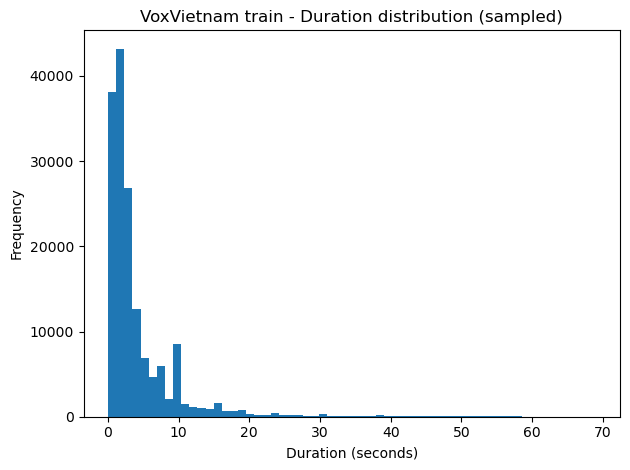

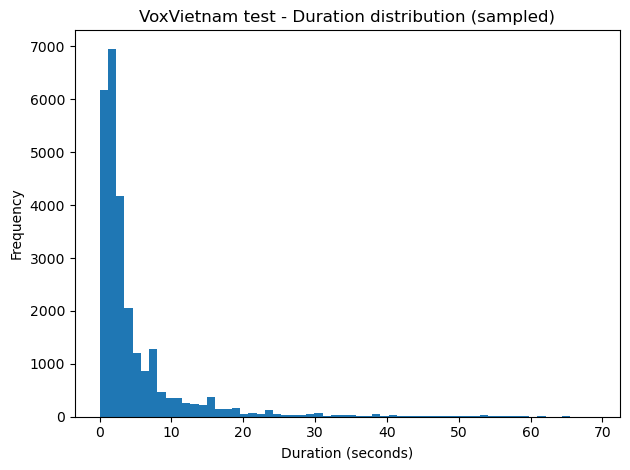

In [ ]:
vox_train_dur = sample_durations(vox_train_files, max_points=200_000)
vox_test_dur  = sample_durations(vox_test_files,  max_points=200_000)

plot_hist(vox_train_dur, bins=60,
          title="VoxVietnam train - Duration distribution (sampled)",
          xlabel="Duration (seconds)")

plot_hist(vox_test_dur, bins=60,
          title="VoxVietnam test - Duration distribution (sampled)",
          xlabel="Duration (seconds)")

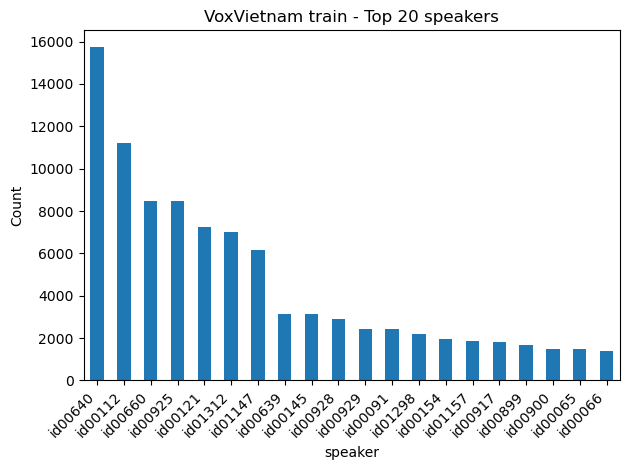

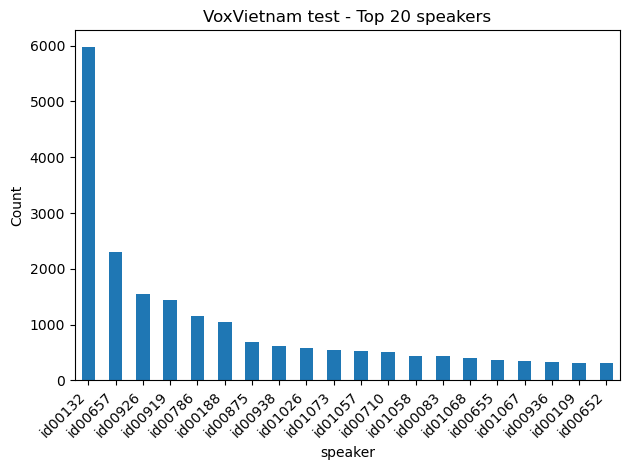

In [ ]:
plot_top_counter(vox_train_stats["text_counters"]["speaker"], topk=20,
                 title="VoxVietnam train - Top 20 speakers",
                 xlabel="speaker")

plot_top_counter(vox_test_stats["text_counters"]["speaker"], topk=20,
                 title="VoxVietnam test - Top 20 speakers",
                 xlabel="speaker")

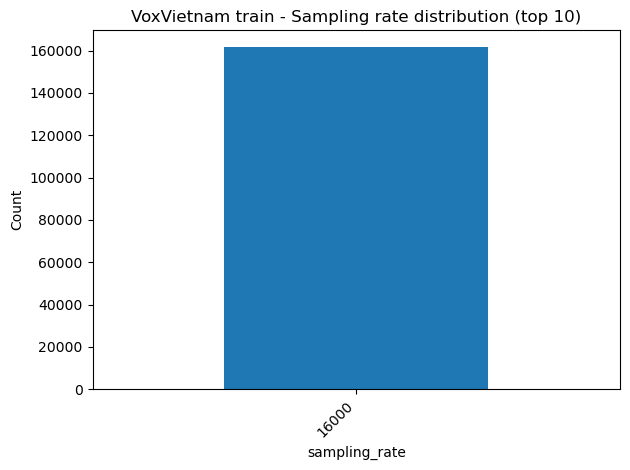

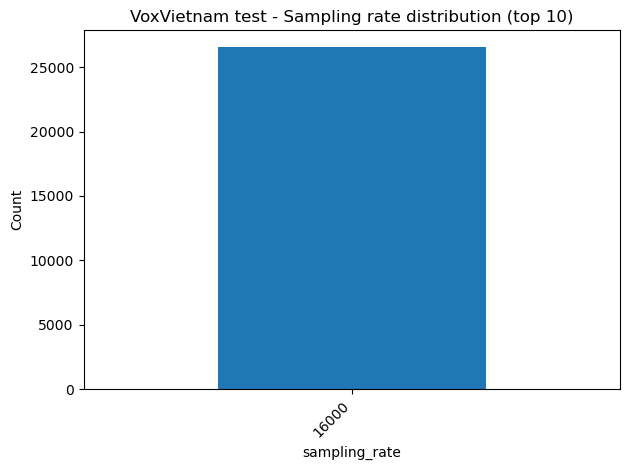

In [ ]:
plot_top_counter(vox_train_stats["sampling_rate_counter"], topk=10,
                 title="VoxVietnam train - Sampling rate distribution (top 10)",
                 xlabel="sampling_rate")

plot_top_counter(vox_test_stats["sampling_rate_counter"], topk=10,
                 title="VoxVietnam test - Sampling rate distribution (top 10)",
                 xlabel="sampling_rate")

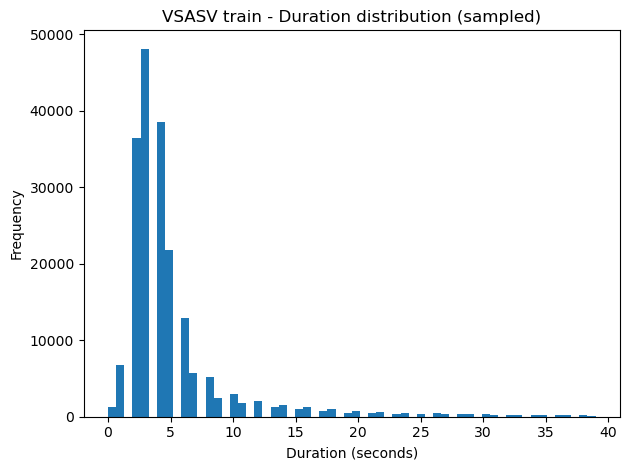

In [ ]:
vsasv_dur = sample_durations(vsasv_train_files, max_points=200_000)

plot_hist(vsasv_dur, bins=60,
          title="VSASV train - Duration distribution (sampled)",
          xlabel="Duration (seconds)")

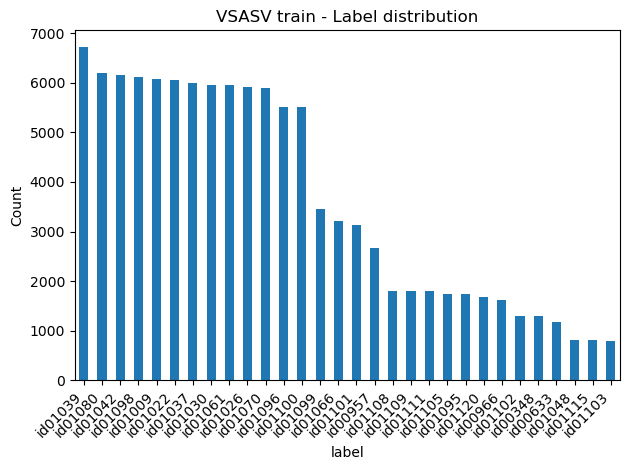

In [ ]:
plot_top_counter(vsasv_stats["text_counters"]["label"], topk=30,
                 title="VSASV train - Label distribution",
                 xlabel="label")

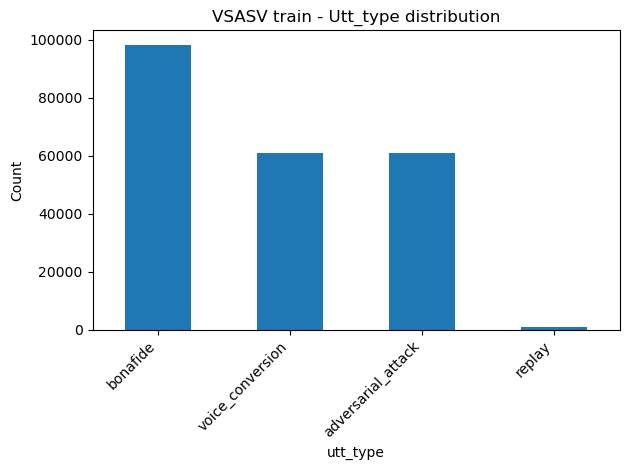

In [ ]:
plot_top_counter(vsasv_stats["text_counters"]["utt_type"], topk=30,
                 title="VSASV train - Utt_type distribution",
                 xlabel="utt_type")

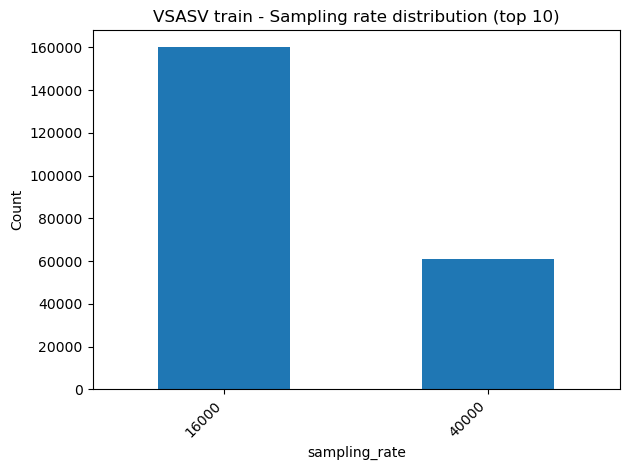

In [ ]:
plot_top_counter(vsasv_stats["sampling_rate_counter"], topk=10,
                 title="VSASV train - Sampling rate distribution (top 10)",
                 xlabel="sampling_rate")

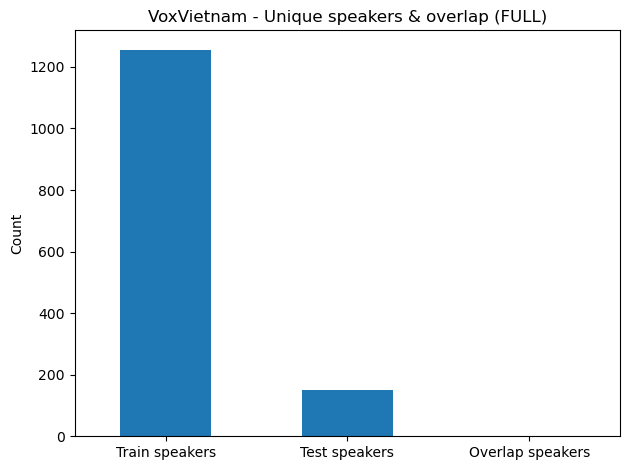

Overlap ratio vs test: 0.0


In [ ]:
train_n = len(train_speakers_full)
test_n  = len(test_speakers_full)
over_n  = len(overlap_full)

counts = pd.Series([train_n, test_n, over_n],
                   index=["Train speakers", "Test speakers", "Overlap speakers"])

plt.figure()
counts.plot(kind="bar")
plt.title("VoxVietnam - Unique speakers & overlap (FULL)")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

print("Overlap ratio vs test:", over_n / max(1, test_n))

# Thống kê số speaker và số utt của từng speaker (đọc tên file)

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# Configuration
folder_path = r'E:\speech_data\train_raw'

def analyze_speech_data(path):
    # Get all files in directory
    files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    
    # Extract speaker IDs (before first '_')
    speakers = [f.split('_')[0] for f in files if '_' in f]
    stats = Counter(speakers)
    
    # Create and sort DataFrame
    df = pd.DataFrame(stats.items(), columns=['Speaker_ID', 'Utterance_Count'])
    df = df.sort_values(by='Utterance_Count', ascending=False)
    
    # Save to CSV
    df.to_csv('speaker_stats.csv', index=False)
    print(f"CSV report saved: speaker_stats.csv")
    
    # Print summary
    print(f"Total Speakers: {len(df)}")
    print(f"Total Utterances: {df['Utterance_Count'].sum()}")
    
    # Plotting distribution
    plt.figure(figsize=(10, 6))
    plt.hist(df['Utterance_Count'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Utterances per Speaker Distribution')
    plt.xlabel('Number of Utterances')
    plt.ylabel('Number of Speakers')
    plt.grid(axis='y', alpha=0.3)
    
    # Save and show plot
    plt.savefig('distribution_plot.png')
    print("Plot saved: distribution_plot.png")
    plt.show()

analyze_speech_data(folder_path)